In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [ ]:
# Data from: https://mmspg.epfl.ch/downloads/food-image-datasets/
# Download the zip file saved in the Drive 
!pip install -U -q PyDrive

#File ID
zip_id = '1C8Fz--k6a9wmqLLif1FvEQcDOYLFqiYJ'

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download the zip file
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('Food-5K.zip')

In [ ]:
# verified that the data has been downloaded
!ls

adc.json  Food-5K.zip  sample_data


In [ ]:
# let's unzip the data
# -qq don't show ouput
!unzip -qq -o Food-5K.zip

In [ ]:
# Show unzip data
!ls

adc.json  Food-5K  Food-5K.zip	__MACOSX  sample_data


In [ ]:
# show training data
# images starting with 0 and images starting with 1

# we'll use thr traing directory for training (Food-5K/training) and 
# validation directory for test
!ls Food-5K

evaluation  training  validation


In [ ]:
# Move directory outside the main folder
!mv Food-5K/* .

In [ ]:
# Show moved directory
!ls

adc.json    Food-5K	 __MACOSX     training
evaluation  Food-5K.zip  sample_data  validation


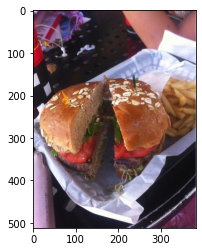

In [ ]:
# Show sample data: check out an image
plt.imshow(image.load_img('training/1_1192.jpg'))
plt.show()

In [ ]:
# now let's set up the proper directory structure
# let start with creating the appropriate directories
# Make appropriate directories 
!mkdir data                           # parent dir
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food
!ls

In [ ]:
# now let's move the data to the appropriate directories
# Move the images
# Note: we will consider 'training' to be the train set
#       'validation' folder will be the test set
#       ignore the 'evaluation' set
!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food

# set up path for training and validation
train_path = 'data/train'
valid_path = 'data/test'

In [ ]:
# process the image : standarization
# These images are pretty big and of different sizes
# Let's load them all in as the same (smaller) size
IMAGE_SIZE = [200, 200]

# useful for getting number of files
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')
print('Number of images for training: ', len(image_files))
print('Number of images for validation: ', len(valid_image_files))


Number of images for training:  3000
Number of images for validation:  1000


In [ ]:
# useful for getting number of classes
folders = glob(train_path + '/*')
print(folders)

['data/train/food', 'data/train/nonfood']


In [ ]:
# STAGE 1
# let's create an instance of the VVG16 using our IMAGE_SIZE
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)

# let's freeze the VVG16 instance stage 1 we created 
# for pretrained model weights
ptm.trainable = False

In [ ]:
# STAGE 2 
# let's create our classifier
# map the data into feature vectors

# Keras image data generator returns classes one-hot encoded
K = len(folders) # number of classes
x = Flatten()(ptm.output)
x = Dense(K, activation='softmax')(x)

# create a model object
# combine stage 1 -- inputs=ptm.input
# and stage 2 -- outputs=x
model = Model(inputs=ptm.input, outputs=x)

# view the structure of the model
model.summary()

In [ ]:
# create an instance of ImageDataGenerator
# this is where we are aolso doing some of the preprocessing
gen_train = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  preprocessing_function=preprocess_input
)

# we don't augment test image but we have to precess them
gen_test = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

# using a batch size of 128
batch_size = 128

# create generators
train_generator = gen_train.flow_from_directory(
  train_path,               # this is the training data path we setup earlier
  shuffle=True,
  target_size=IMAGE_SIZE,   # image size that we define for standarization
  batch_size=batch_size,
)
valid_generator = gen_test.flow_from_directory(
  valid_path,               # this is the validation data path we setup earlier
  target_size=IMAGE_SIZE,   # image size that we define for standarization
  batch_size=batch_size,
)

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# Now let's train our model
# fit the model
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=10,
  steps_per_epoch=int(np.ceil(len(image_files) / batch_size)),
  validation_steps=int(np.ceil(len(valid_image_files) / batch_size)),
)

Epoch 1/10
24/24 [==============================] - 79s 2s/step - loss: 2.2948 - accuracy: 0.9027 - val_loss: 0.4059 - val_accuracy: 0.9800
Epoch 2/10
24/24 [==============================] - 47s 2s/step - loss: 0.4660 - accuracy: 0.9797 - val_loss: 0.4389 - val_accuracy: 0.9760
Epoch 3/10
24/24 [==============================] - 47s 2s/step - loss: 0.4280 - accuracy: 0.9820 - val_loss: 0.3735 - val_accuracy: 0.9820
Epoch 4/10
24/24 [==============================] - 47s 2s/step - loss: 0.1814 - accuracy: 0.9867 - val_loss: 0.3602 - val_accuracy: 0.9810
Epoch 5/10
24/24 [==============================] - 47s 2s/step - loss: 0.1885 - accuracy: 0.9870 - val_loss: 0.3962 - val_accuracy: 0.9790
Epoch 6/10
24/24 [==============================] - 46s 2s/step - loss: 0.1472 - accuracy: 0.9890 - val_loss: 0.5420 - val_accuracy: 0.9770
Epoch 7/10
24/24 [==============================] - 46s 2s/step - loss: 0.1672 - accuracy: 0.9900 - val_loss: 0.7403 - val_accuracy: 0.9740
Epoch 8/10
24/24 [==

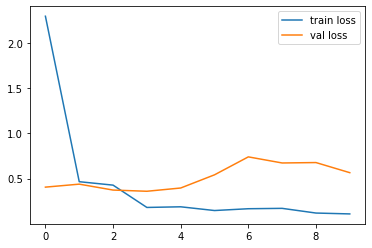

In [ ]:
# Plot loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

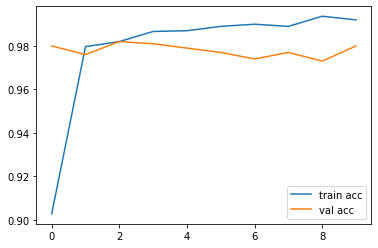

In [ ]:
# Plot accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()